# Introduction

# Data source

The MNIST database of handwritten digits, available from [THE MNIST DATABASE](http://yann.lecun.com/exdb/mnist/), has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

Scikit-Learn has function `fetch_openml` to download popular datasets like MNIST digits dataset.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

C:\Python310\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# Data exploration

In [2]:
X, Y = mnist.data, mnist.target

Let's look the dimenstion of X.

In [3]:
X.shape

(70000, 784)

X has 70,000 rows and 784 columns. It means that there are 70,000 images and 784 features(columns) are vector representation of 28X28 pixels. Each pixel is has value from 0 to 255. So each of 784 features represents a pixel's intensity.

In [4]:
Y.shape

(70000,)

Y has 70,000 labels for corresponding images in X.

Let's explore some digits.

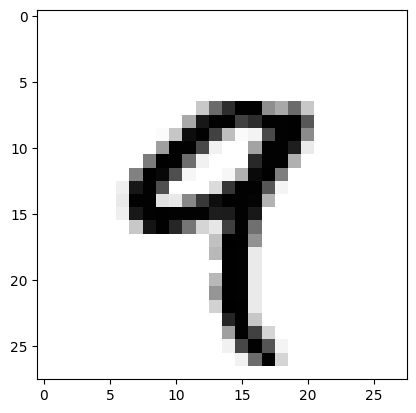

In [5]:
import matplotlib.pyplot as plt

def show_image(digit_data):
    digit_pixels = digit_data.reshape(28, 28)
    plt.imshow(digit_pixels, cmap="binary")
    
digit_data_i = X[4]
show_image(digit_data_i)

This looks like 9. Let's check.

In [6]:
Y[4]

'9'

# Train test split

The dataset contains training and test set. The first 60,000 values are for training and remaining 10,000 are for testing.

In [7]:
X_train = X[:60000]
Y_train = Y[:60000]
X_test = X[60000:]
Y_test = Y[60000:]

# Trainig a binary classifier

Let's build a model to classify 9 vs non-9.

Labels for 9 vs non-9.

In [8]:
Y_train_9 = (Y_train == "9")
Y_train_9

array([False, False, False, ..., False, False, False])

In [9]:
Y_test_9 = (Y_test == "9")
Y_test_9

array([False, False, False, ..., False, False, False])

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_cls = SGDClassifier(random_state=2)
sgd_cls.fit(X_train, Y_train_9)

SGDClassifier(random_state=2)

# Evaluating binary classification performance

In [11]:
from sklearn.model_selection import cross_val_predict

Y_train_pred = cross_val_predict(sgd_cls, X_train, Y_train_9, cv=3)

Y_train_pred

array([False, False, False, ..., False, False, False])

Let's build confusion matrix to examine the performance.

In [12]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_train_9, Y_train_pred)

cm

array([[52232,  1819],
       [ 1547,  4402]], dtype=int64)

Let's evaluate the F1 score.

In [13]:
from sklearn.metrics import f1_score

f1_score(Y_train_9, Y_train_pred)

0.72341824157765

## Precision vs recall

Let's plot precision vs recall curve to choose the best threeshold.

In [14]:
from sklearn.metrics import precision_recall_curve

Y_scores = cross_val_predict(sgd_cls, X_train, Y_train_9, cv=3, method="decision_function")

precision, recall, threeshold = precision_recall_curve(Y_train_9, Y_scores)



In [15]:
precision

array([0.09915   , 0.09915165, 0.09915331, ..., 1.        , 1.        ,
       1.        ])

In [16]:
recall

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       3.36190956e-04, 1.68095478e-04, 0.00000000e+00])

In [17]:
threeshold

array([-126352.33483152, -124086.02296364, -123668.35584149, ...,
         26033.70834703,   28812.21213995,   31292.37343978])

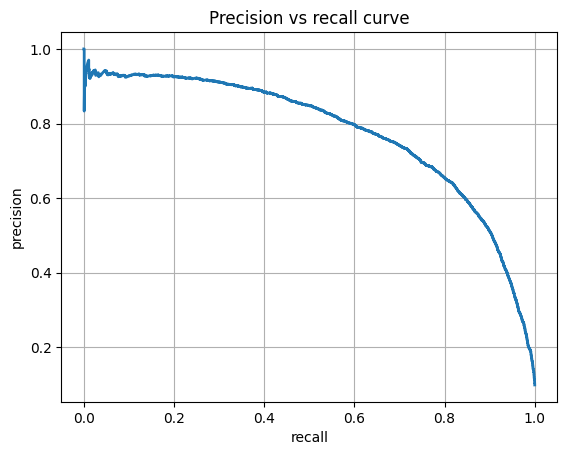

In [18]:
plt.plot(recall, precision, linewidth=2, label="precision vs recall curve")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Precision vs recall curve")
plt.grid()
plt.show()

Let's aim for 90% precision.

In [19]:
idx_prec_90 = (precision >= 0.90).argmax()

threeshold_prec_90 = threeshold[idx_prec_90]

threeshold_prec_90

5458.3934625909205

In [20]:
Y_train_9_predict = (Y_scores > threeshold_prec_90)
Y_train_9_predict

array([False, False, False, ..., False, False, False])

Let's check precision and recall score.

In [21]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(Y_train_9, Y_train_9_predict)

recall = recall_score(Y_train_9, Y_train_9_predict)

print("Precision: ", precision)
print("Recall: ", recall)

Precision:  0.900043840420868
Recall:  0.3451000168095478


# Multiclass classification

Let's do multiclass classification so that the model can predict the class from 10 classes (one for each digit) of each input.

The SGDClassifier can be used to train multiclass model. It uses one vs rest binary strategy for the multiclass classfication.

In [27]:
sgd_multiclass = SGDClassifier(random_state=2)

sgd_multiclass.fit(X_train, Y_train)

SGDClassifier(random_state=2)

In [28]:
sgd_multiclass.predict([X_train[2501]])

array(['9'], dtype='<U1')

In [29]:
Y_train[2501]

'9'

# Evaluating the multiclass classification model

In [45]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(sgd_multiclass, X_train, Y_train, cv=3)

score

array([0.87355, 0.86865, 0.8742 ])

In [46]:
score.mean()

0.8721333333333333

So we have 87% accuracy.

Let's plot the confusion matrix to evaluate the model's predictions.

In [31]:
Y_train_predict = cross_val_predict(sgd_multiclass, X_train, Y_train, cv=3)

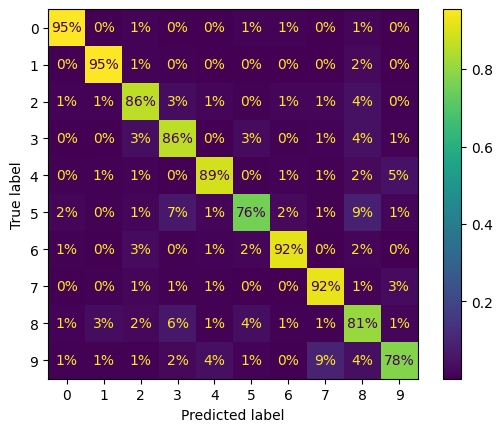

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(Y_train, Y_train_predict, normalize="true", values_format=".0%")
plt.show()

The percentages in the diagonal are correct prediction percentages.

Let's plot the errors using the confusion matrix. The following matrix only contains the errors and their predicted classes. The correct predictions have zero weight.

In [39]:
sample_weight = (Y_train_predict != Y_train)

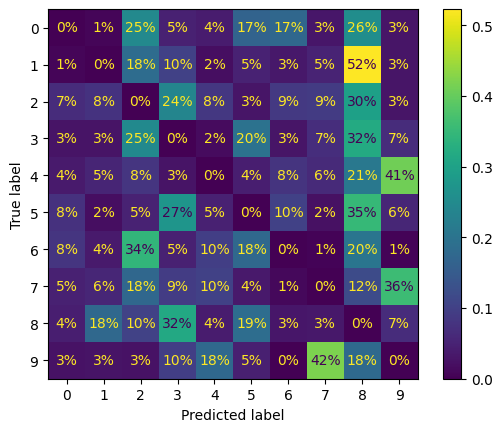

In [42]:
ConfusionMatrixDisplay.from_predictions(Y_train, Y_train_predict, sample_weight=sample_weight, normalize="true", values_format=".0%")
plt.show()

Here the percentages are the from incorrect predictions. For example - row of digit 1 (2nd row) and column of digit 8 (9th column) contains 52%, which means 52% of all mis-classified "1"s ("1" incorrectly classified as some other digit) were mis-classified as 8.

# Evaluating the model using the testing set

In [48]:
Y_test_predict = sgd_multiclass.predict(X_test)

Y_test_predict

array(['7', '2', '1', ..., '4', '5', '6'], dtype='<U1')

In [50]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_test, Y_test_predict)

0.7956

So the accuracy is almost 80% on the training set.

Let's plot the confusion matrix for all predictions.

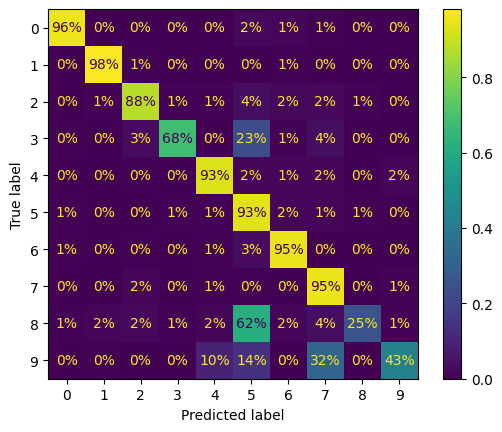

In [51]:
ConfusionMatrixDisplay.from_predictions(Y_test, Y_test_predict, normalize="true", values_format=".0%")
plt.show()

Oops the model makes very poor predictions for the digit "3", "8" and "9". The correct predictions for "8" and "9" is less than 50% which is dissapointing.

Let's plot the confusion matrix to check which classes the model is putting the mis-classified digits into.

In [52]:
sample_weight = (Y_test_predict != Y_test)

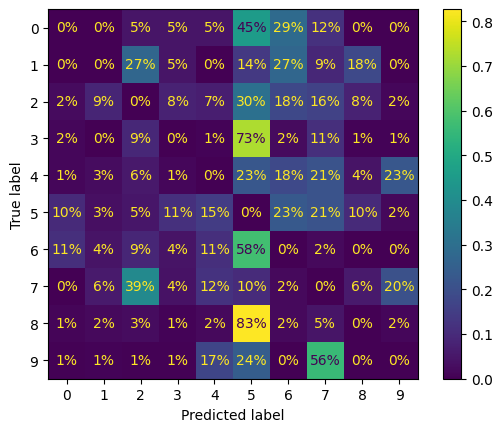

In [53]:
ConfusionMatrixDisplay.from_predictions(Y_test, Y_test_predict, sample_weight=sample_weight, normalize="true", values_format=".0%")
plt.show()

So majority of the mis-classified digits are classified as "5" (digits "0", "2", "3", "4", "6", "8").

More advanced methods can be used to improve the classifications.